In [2]:
import pickle
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from Helpers.Grae import get_GRAE_networks, BaseDataset


In [3]:

"""
This script pulls in one of Marshall's embeddings to validate how well it predicts the test points embedded by GRAE
"""

import sys
sys.path.append('/yunity/msn39/ADNI-Modeling-Dashboard')  # So we can get to the ADNI Dataset class
import ADNI_Dataset_Class


# Define the path to the pickle file
file_path = os.path.join('Datasets', 'Embeddings', 'your_pickle_file.pkl')

# Load the pickle files for the desired manifold alignment, embeddings, and dataset objects

folder_name = os.listdir("/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/")[0]
emb_folder = "/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/" + folder_name

emb_folder = "/yunity/msn39/ADNI-Modeling-Dashboard/Datasets/Embeddings/MASH_Visit Variables 2025-03-07-10-42_DX_DX2_use_rf_proximities_selection-ADNI3_2025-Mar-07-@-03-31_Visit Variables 2025-03-05-16-01_DX_DX2_use_rf_proximities_selection-ADNI3_2025-Mar-07-@-03-32_2025-Mar-07-@-04-42"

with open(emb_folder + '/class_object.pkl', 'rb') as file:
    mash_object = pickle.load(file)
with open(emb_folder + '/domain_object_1.pkl', 'rb') as file:
    domain_1_object = pickle.load(file)
with open(emb_folder + '/domain_object_2.pkl', 'rb') as file:
    domain_2_object = pickle.load(file)

In [4]:
print(mash_object.emb)

[[ 0.21139157  0.42461045]
 [-0.06606136 -0.10205079]
 [-0.4249711  -0.07893213]
 ...
 [-0.00468094 -0.01256227]
 [ 0.08548338  0.06399786]
 [-0.16717932  0.18158922]]


In [5]:
mash_object.emb

array([[ 0.21139157,  0.42461045],
       [-0.06606136, -0.10205079],
       [-0.4249711 , -0.07893213],
       ...,
       [-0.00468094, -0.01256227],
       [ 0.08548338,  0.06399786],
       [-0.16717932,  0.18158922]])

In [6]:
X_train = mash_object.emb
y_train = pd.concat([domain_1_object.labels, domain_2_object.labels])  # Resets index after appending

# Train a Random Forest Classifier
embedding_based_model = RandomForestClassifier(n_estimators=100, random_state=42)
embedding_based_model.fit(X_train, y_train)

# print a not-meaningful evaluation of the embedding just to make sure we didn't pass something incorrectly
scores = cross_val_score(embedding_based_model, X_train, y_train, cv=3)

print(scores)


[0.68346697 0.71821306 0.70359053]


In [7]:
graeA, graeB = get_GRAE_networks(domain_1_object.data, domain_2_object.data, mash_object.emb, n_comp = 2, 
                  anchors = mash_object.known_anchors, labelsA = domain_1_object.labels, labelsB = domain_2_object.labels)

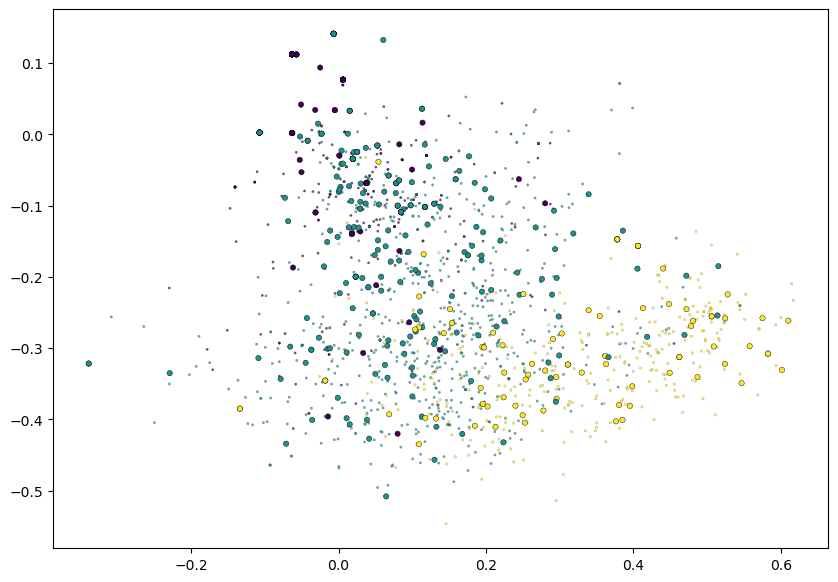

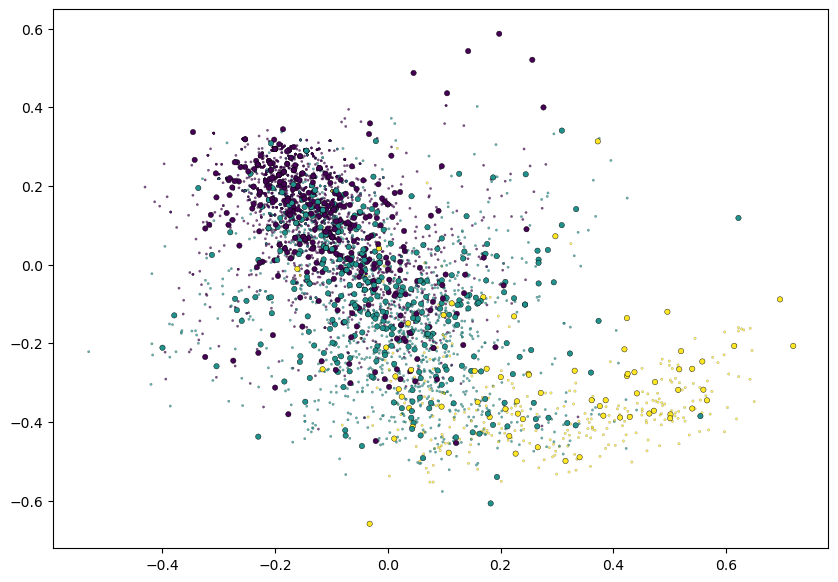

In [8]:
A_X_train_grae = BaseDataset(domain_1_object.data, np.array(domain_1_object.labels), split="none", split_ratio=0.8, random_state=42) #is there an error here
B_X_train_grae = BaseDataset(domain_2_object.data, np.array(domain_2_object.labels), split="none", split_ratio=0.8, random_state=42)

A_X_test_grae = BaseDataset(domain_1_object.test_data, np.array(domain_1_object.test_labels), split="none", split_ratio=0.8, random_state=42)
B_X_test_grae = BaseDataset(domain_2_object.test_data, np.array(domain_2_object.test_labels), split="none", split_ratio=0.8, random_state=42)

graeA.plot(A_X_train_grae, A_X_test_grae, cmap="viridis")
graeB.plot(B_X_train_grae, B_X_test_grae, cmap="viridis")

In [9]:
print(domain_1_object.type)
print(domain_2_object.type)

visit
visit


In [10]:
# See how accurate it is on the test points
new_embedded_points_A = graeA.transform(A_X_test_grae)
new_embedded_points_B = graeB.transform(B_X_test_grae)

# Predict on the test sets
predictions_A = embedding_based_model.predict(new_embedded_points_A)
predictions_B = embedding_based_model.predict(new_embedded_points_B)

# Evaluate accuracy
accuracy_A = accuracy_score(domain_1_object.test_labels, predictions_A)
accuracy_B = accuracy_score(domain_2_object.test_labels, predictions_B)


# Print all accuracy scores

domain_1_dataset_score = domain_1_object.dataset_accuracy
domain_1_distances_score = domain_1_object.distances_accuracy
domain_2_dataset_score = domain_2_object.dataset_accuracy
domain_2_distances_score = domain_2_object.distances_accuracy
manifold_oob = mash_object.get_scores(labels=y_train, n_jobs=-1)

print(f"Beginning Dataset A Score: {domain_1_dataset_score}")
print(f"Beginning Dataset B Score: {domain_2_dataset_score}")
print(f"Practical Test Accuracy A: {accuracy_A:.4f}")
print(f"Practical Test Accuracy B: {accuracy_B:.4f}")

RF-GAP score is R^2
Calculating the R squared score.
Beginning Dataset A Score: 0.7063583815028902
Beginning Dataset B Score: 0.6302083333333334
Practical Test Accuracy A: 0.6613
Practical Test Accuracy B: 0.6263


In [11]:
def denormalize_data(normalized_data, min_vals, max_vals):
    if isinstance(normalized_data, np.ndarray):
        return normalized_data * (max_vals - min_vals) + min_vals
    
    elif isinstance(normalized_data, pd.DataFrame):
        return normalized_data * (max_vals - min_vals) + min_vals
    
    else:
        raise ValueError("Input should be a NumPy array or a Pandas DataFrame.")
    
B_transformed_to_A = graeA.inverse_transform(new_embedded_points_B)
A_transformed_to_B = graeB.inverse_transform(new_embedded_points_A)

B_transformed_to_A = denormalize_data(B_transformed_to_A, domain_1_object.test_min_vals, domain_1_object.test_max_vals)
A_transformed_to_B = denormalize_data(A_transformed_to_B, domain_2_object.test_min_vals, domain_2_object.test_max_vals)

original_A = denormalize_data(domain_1_object.test_data, domain_1_object.test_min_vals, domain_1_object.test_max_vals)
original_B = denormalize_data(domain_2_object.test_data, domain_2_object.test_min_vals, domain_2_object.test_max_vals)

In [12]:
original_A_df = pd.DataFrame(original_A)
original_A_df['RID'] = list(domain_1_object.test_rids)
original_A_df['VISMONTH'] = list(domain_1_object.test_vismonth)

original_B_df = pd.DataFrame(original_B)
original_B_df['RID'] = list(domain_2_object.test_rids)
original_B_df['VISMONTH'] = list(domain_2_object.test_vismonth)

In [13]:
#they don't automatically line up by the same RIDs so we're going to need to fix that

B_transformed_to_A_df = pd.DataFrame(B_transformed_to_A)
B_transformed_to_A_df['RID'] = list(domain_2_object.test_rids)
B_transformed_to_A_df['VISMONTH'] = list(domain_2_object.test_vismonth)
A_transformed_to_B_df = pd.DataFrame(A_transformed_to_B)
A_transformed_to_B_df['RID'] = list(domain_1_object.test_rids)
A_transformed_to_B_df['VISMONTH'] = list(domain_1_object.test_vismonth)

In [14]:
# PAY ATTENTION TO WHICH IS TRANSLATING TO WHICH HERE
from sklearn.metrics import mean_squared_error

# Merge the dataframes on 'RID' and 'VISMONTH'
merged_df = pd.merge(B_transformed_to_A_df, original_A_df, on=['RID', 'VISMONTH'], suffixes=('_transformed', '_original'))

# Calculate the mean squared error for the values besides 'RID' and 'VISMONTH'
mse = mean_squared_error(merged_df.filter(regex='_transformed$').values, merged_df.filter(regex='_original$').values)

rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Squared Error: {mse}")

Root Mean Squared Error: 1.4837749499460025
Mean Squared Error: 2.2015881020872623


In [15]:
# Merge the dataframes on 'RID' and 'VISMONTH'
merged_df_B = pd.merge(A_transformed_to_B_df, original_B_df, on=['RID', 'VISMONTH'], suffixes=('_transformed', '_original'))

# Calculate the mean squared error for the values besides 'RID' and 'VISMONTH'
mse_B = mean_squared_error(merged_df_B.filter(regex='_transformed$').values, merged_df_B.filter(regex='_original$').values)

rmse_B = np.sqrt(mse_B)
print(f"Root Mean Squared Error for B: {rmse_B}")
print(f"Mean Squared Error for B: {mse_B}")

Root Mean Squared Error for B: 1.1264828509783549
Mean Squared Error for B: 1.2689636135483224
